In [1]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from attention import Attention

In [2]:
#input test data
test_df = pd.read_csv('../dataset/sst5/sst_test.txt', sep='\t', header=None,
                   names=['truth', 'text'],
                  )
test_df['truth'] = test_df['truth'].str.replace('__label__', '')
test_df['truth'] = test_df['truth'].astype(int).astype('category')
test_df.tail()


,truth,text
2205,4,An imaginative comedy/thriller .
2206,5,"( A ) rare , beautiful film ."
2207,5,( An ) hilarious romantic comedy .
2208,4,Never ( sinks ) into exploitation .
2209,1,( U ) nrelentingly stupid .


In [3]:
#add length column
test_df['len'] = test_df['text'].str.len()
test_df.head()

,truth,text,len
0,3,Effective but too-tepid biopic,30
1,4,If you sometimes like to go to the movies to h...,89
2,5,"Emerges as something rare , an issue movie tha...",113
3,3,The film provides some great insight into the ...,138
4,5,Offers that rare combination of entertainment ...,61


In [4]:
#input training data
train_df = pd.read_csv('../dataset/sst5/sst_train.txt', sep='\t', header=None,
                   names=['truth', 'text'],
                  )
train_df['truth'] = train_df['truth'].str.replace('__label__', '')
train_df['truth'] = train_df['truth'].astype(int).astype('category')

train_df['len'] = train_df['text'].str.len()
train_df.head()

,truth,text,len
0,4,The Rock is destined to be the 21st Century 's...,181
1,5,The gorgeously elaborate continuation of `` Th...,226
2,4,Singer/composer Bryan Adams contributes a slew...,208
3,3,You 'd think by now America would have had eno...,100
4,4,Yet the act is still charming here .,36


In [5]:
#concatenate of train and test data
df = pd.concat([train_df, test_df], axis = 0)
df.to_csv("../dataset/sst5/sst5.csv",index=False)
df.head()

,truth,text,len
0,4,The Rock is destined to be the 21st Century 's...,181
1,5,The gorgeously elaborate continuation of `` Th...,226
2,4,Singer/composer Bryan Adams contributes a slew...,208
3,3,You 'd think by now America would have had eno...,100
4,4,Yet the act is still charming here .,36


In [6]:
#save training data
train_df.to_csv("../dataset/sst5/sst5_train.csv",index=False)
train_df.head()

,truth,text,len
0,4,The Rock is destined to be the 21st Century 's...,181
1,5,The gorgeously elaborate continuation of `` Th...,226
2,4,Singer/composer Bryan Adams contributes a slew...,208
3,3,You 'd think by now America would have had eno...,100
4,4,Yet the act is still charming here .,36


In [7]:
#save testing data
test_df.to_csv("../dataset/sst5/sst5_test.csv",index=False)
test_df.head()

,truth,text,len
0,3,Effective but too-tepid biopic,30
1,4,If you sometimes like to go to the movies to h...,89
2,5,"Emerges as something rare , an issue movie tha...",113
3,3,The film provides some great insight into the ...,138
4,5,Offers that rare combination of entertainment ...,61


In [8]:
#max_sentence_len = 267
temp_df = train_df.sort_values(['len'], ascending=True)
print(temp_df.tail())

     truth                                               text  len
4155     1  Even if the enticing prospect of a lot of nubi...  260
1940     4  Filmmakers Dana Janklowicz-Mann and Amir Mann ...  260
251      5  I stopped thinking about how good it all was ,...  260
925      4  Notwithstanding my problem with the movie 's f...  261
39       4  ... spiced with humor ( ' I speak fluent flatu...  267


Text(0, 0.5, 'Label')

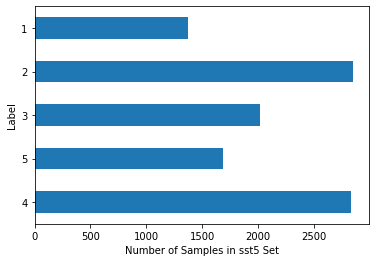

In [9]:
#data distribution
data = pd.read_csv("../dataset/sst5/sst5.csv")
ax = data['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in sst5 Set")
ax.set_ylabel("Label")

In [10]:
#read data and convert to texts_list
df = pd.read_csv("../dataset/sst5/sst5.csv")
labels = np.array(df['truth'])
texts = np.array(df['text'])
labels_list = labels.tolist()
texts_list = texts.tolist()
texts_list[0]

"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."

In [11]:
#tokenizing
from data_prepare import DataPrepare
text_data_prepare = DataPrepare()
texts_list = [s.strip() for s in texts_list]
texts_list = [text_data_prepare.clean_str(sent) for sent in texts_list]
texts_list = [s.split(" ") for s in texts_list]
texts_list[0]

['the',
 'rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'century',
 "'s",
 'new',
 '``',
 'conan',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'arnold',
 'schwarzenegger',
 ',',
 'jean',
 'claud',
 'van',
 'damme',
 'or',
 'steven',
 'segal']

In [12]:
#generate vocabulary dictionary and correlated data X
sentences_padded = text_data_prepare.pad_sentences(texts_list)
vocabulary, vocabulary_inv = text_data_prepare.build_vocab(sentences_padded)
X = np.array([[vocabulary[word] for word in sentence] for sentence in sentences_padded])
X.shape

(10754, 56)

In [13]:
#encoding labels for sentiments classification
lb = LabelEncoder()
y_train_old = labels
print(y_train_old.shape)
y = np_utils.to_categorical(lb.fit_transform(labels))
y_train_old

(10754,)


array([4, 5, 4, ..., 5, 4, 1])

In [14]:
#split testing and training
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8603, 56)
(8603, 5)
(2151, 56)
(2151, 5)


In [15]:
#set hyperparameters and configurations of model
sequence_length = X.shape[1] # 56
print("sequence_length:",sequence_length)
vocabulary_size = len(vocabulary_inv) # 18765
print("vocabulary_size:",vocabulary_size)
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.3

epochs = 50
batch_size = 32

sequence_length: 56
vocabulary_size: 17088


In [16]:
#create model based on TextCNN，concatenate after convolutional network
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_0 = Dropout(rate=drop)(conv_0)

conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Dropout(rate=drop)(conv_1)

conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Dropout(rate=drop)(conv_2)

#conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
#conv_3 = Dropout(rate=drop)(conv_3)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
#maxpool_3 = MaxPool2D(pool_size=(sequence_length - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_3)
#concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
att = Reshape((1, -1))(dropout)
att = Dense(units=768, activation='relu')(att)
att = Dropout(drop)(att)
att = Attention(units=256)(att)
output = Dense(units=5, activation='softmax')(att)
#output = Dense(units=5, activation='softmax')(dropout)
# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 56, 256)      4374528     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 56, 256, 1)   0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 54, 1, 512)   393728      ['reshape[0][0]']                
                                                                                              

2022-05-11 19:27:43.604442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 19:27:43.605064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 19:27:43.609150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-05-11 19:27:43.609749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-11 19:27:43.609762: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU 

In [24]:
#model training
from tensorflow.python.framework import ops
from keras import losses
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
print("Traning Model...")
model.compile(optimizer=adam, loss=losses.categorical_crossentropy, metrics=['acc'])
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))  # starts training


Traning Model...
Epoch 1/20
269/269 [==============================] - 24s 88ms/step - loss: 1.5814 - acc: 0.2627 - val_loss: 1.5677 - val_acc: 0.3045
Epoch 2/20
269/269 [==============================] - 24s 88ms/step - loss: 1.5140 - acc: 0.3356 - val_loss: 1.5012 - val_acc: 0.3482
Epoch 3/20
269/269 [==============================] - 24s 88ms/step - loss: 1.3148 - acc: 0.4493 - val_loss: 1.4043 - val_acc: 0.3715
Epoch 4/20
269/269 [==============================] - 24s 88ms/step - loss: 0.9786 - acc: 0.6058 - val_loss: 1.3608 - val_acc: 0.4031
Epoch 5/20
269/269 [==============================] - 24s 88ms/step - loss: 0.6388 - acc: 0.7780 - val_loss: 1.4369 - val_acc: 0.3989
Epoch 6/20
269/269 [==============================] - 24s 88ms/step - loss: 0.3455 - acc: 0.9025 - val_loss: 1.5446 - val_acc: 0.3817
Epoch 7/20
269/269 [==============================] - 24s 89ms/step - loss: 0.1824 - acc: 0.9550 - val_loss: 1.6694 - val_acc: 0.3970
Epoch 8/20
269/269 [=========================

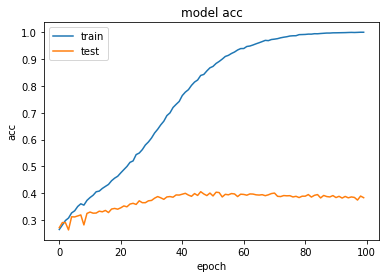

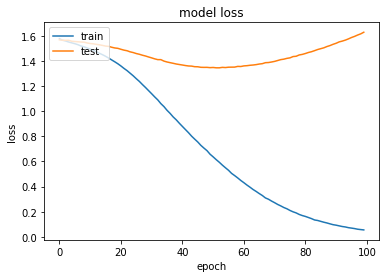

In [74]:
from plot import plot_loss_curve, plot_acc_curve
plot_acc_curve(model_history)
plot_loss_curve(model_history)

accuracy: 41.93%
135/135 - 1s - 969ms/epoch - 7ms/step


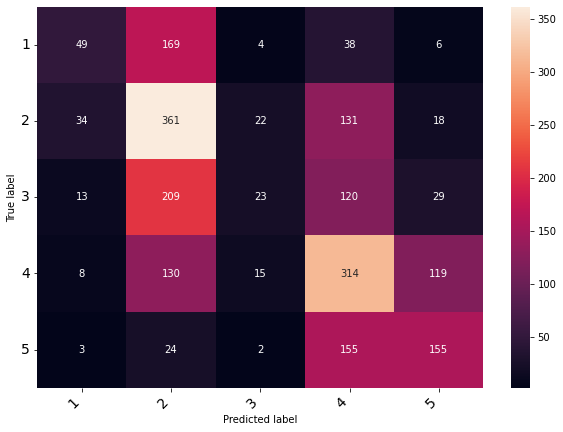

In [111]:
from plot import plot_confusion_matrix
labels = ['1','2','3','4','5']
plot_confusion_matrix(model, X_test, y_test, labels, lb)

In [17]:

#training
from tensorflow.python.framework import ops
from keras import losses
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
print("Traning Model...")
model.compile(optimizer=adam, loss=losses.categorical_crossentropy, metrics=['acc'])

Traning Model...
